In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from math import sqrt
from scipy.optimize import linear_sum_assignment
from scipy.stats import t
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial import KDTree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance_matrix
from tsp_solver.greedy import solve_tsp
from sklearn.metrics import r2_score

def efficient_min_distance_method(samples,p):
    tree = KDTree(samples)
    min_distance = np.inf
    closest_pair = (0, 0)

    for i in range(samples.shape[0]):
        distances, indices = tree.query(samples[i], k=2, p=p)  # k=2 返回最近的两个点（包括自身）
        if distances[1] < min_distance:  # distances[1] 是第二近的点（即除了自身外最近的点）
            min_distance = distances[1]
            closest_pair = (i, indices[1])

    return closest_pair

def K_Space(cluster_nums, samples, p=2):

    n = samples.shape[0]
    num_each_cluster = n // cluster_nums
    clusters = [[] for _ in range(cluster_nums+1)]
    cluster_centers = []
    samples_remaining = samples.copy()
    add_cluster_index = 0
    clusters_ = []
    time = 0

    while samples_remaining.shape[0] + len(cluster_centers)>1:
        #打印每次迭代的效果
        
        # print(f"第{time}次循环 samples_reminding:{samples_remaining.shape[0]} 临时类数量:{len(cluster_centers)} 产出类数量:{len(clusters_)}")
        
        matrix = np.vstack([samples_remaining,[i for i in cluster_centers]]) if len(cluster_centers)>0 else samples_remaining
        #首先计算合并的矩阵中距离最近的两个元素
        index1, index2 = efficient_min_distance_method(matrix,p=p)
        #求得两个元素是样本还是簇心
        label1 = 0 if index1 < samples_remaining.shape[0] else 1 # 0表示样本,1表示簇心
        label2 = 0 if index2 < samples_remaining.shape[0] else 1
        
        #样本点之间的合并
        if add_cluster_index < len(clusters) and label1+label2 == 0:
            clusters[add_cluster_index].extend([samples_remaining[index1], samples_remaining[index2]])
            cluster_centers.append(np.mean(clusters[add_cluster_index], axis=0))
            samples_remaining = np.delete(samples_remaining, [index1, index2], axis=0)
            add_cluster_index += 1
            # print(f"样本合并创建新类 ")
            
        #当簇的数量足够时,如果还是两个样本,则将两个样本作为一个整体加入距离簇心最近的类中
        elif add_cluster_index == len(clusters) and label1+label2 == 0:
            two_samples_mean = np.mean([samples_remaining[index1], samples_remaining[index2]],axis=0)
            # print(cluster_centers)
            # print(clusters)
            # print(clusters_)
            if add_cluster_index == 0 and len(clusters) == 0:
                clusters.append([])
                clusters.append([])
                clusters[add_cluster_index].extend([samples_remaining[index1], samples_remaining[index2]])
                cluster_centers.append(np.mean(clusters[add_cluster_index], axis=0))
                samples_remaining = np.delete(samples_remaining, [index1, index2], axis=0)
                add_cluster_index += 1
                # print(f"类数已充足,增加类数")
            else:
                cluster_centers_matrix = np.vstack([i for i in cluster_centers])
                tree = KDTree(cluster_centers_matrix)
                _, indices = tree.query(two_samples_mean, k=1, p=p)
                clusters[indices].extend([samples_remaining[index1], samples_remaining[index2]])
                cluster_centers[indices] = np.mean(clusters[indices], axis=0)
                samples_remaining = np.delete(samples_remaining, [index1,index2], axis=0)
                # print(f"两个样本归纳新类")
            
        #样本点添加到类中
        elif label1+label2 == 1:
            index_samples = index1 if label1 == 0 else index2
            index_cluster = index1-samples_remaining.shape[0] if label1 == 1 else index2-samples_remaining.shape[0]
            clusters[index_cluster].append(samples_remaining[index_samples])
            cluster_centers[index_cluster] = np.mean(clusters[index_cluster], axis=0)
            samples_remaining = np.delete(samples_remaining, index_samples, axis=0)
            # print(f"一个样本归纳新类")
           
        #类与类之间的合并
        else:
            index1 = index1 - samples_remaining.shape[0]
            index2 = index2 - samples_remaining.shape[0]
            if len(clusters[index1])+len(clusters[index2]) <= num_each_cluster:#如果两个类中样本合并的数量不足饱和
                clusters[index1] = clusters[index1]+clusters[index2]
                cluster_centers[index1] = np.mean(clusters[index1], axis=0)
                del clusters[index2]
                del cluster_centers[index2]
                add_cluster_index -= 1
            #使用lof算法剔除多余样本点
            else:
                points = np.vstack([clusters[index1]+clusters[index2]])
                del clusters[max(index1,index2)]
                del clusters[min(index1,index2)]
                del cluster_centers[max(index1,index2)]
                del cluster_centers[min(index1,index2)]
                lof_model = LocalOutlierFactor(n_neighbors=int(num_each_cluster/2),p=p)
                lof_model.fit_predict(points)
                score = abs(lof_model.negative_outlier_factor_)
                clusters_.append(list(points[np.argsort(score)[:num_each_cluster]]))
                samples_remaining = np.vstack([samples_remaining,points[np.argsort(score)[num_each_cluster:]]])
                add_cluster_index -= 2
            clusters.append([])
            # print(f"两个类合并")
            
        time += 1
        #剔除已经饱和的簇
        for i in range(add_cluster_index):
            if len(clusters[i]) >= num_each_cluster:
                clusters_.append(clusters[i])
                del clusters[i]
                del cluster_centers[i]
                add_cluster_index -= 1
                break
        #将最后剩余的样本点归纳为一个类
        if samples_remaining.shape[0] + len(cluster_centers) == 1:
            if len(clusters) == 0:
                break
            clusters_.append(clusters[0])
            

    return clusters_

#计算聚类效果
def calculate_indicator(samples,label):
    clusters_center = []
    for i in range(np.max(label+1)):
        center = np.mean(samples[np.where(label==i)],axis=0)
        clusters_center.append(center)
    clusters_center = np.array(clusters_center)
    m = 0
    for i in range(samples.shape[0]):
        distance = np.linalg.norm(samples[i,:]-clusters_center,axis=1)
        if np.argmin(distance) != label[i]:
            m += 1
            
    return m/samples.shape[0]
    
def list_transform_array(clusters):
    x_train = []
    y_train = []
    max_depth = int(len(clusters)/3)
    #将原本聚类结果完全转化为列表,导出label
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            x_train.append(clusters[i][j])
            y_train.append(i)
    #将列表格式的数据转化为数组
    x_train = np.vstack(x_train)
    y_train = np.array(y_train)
    return x_train,y_train
    
def fine_turning(x_train,y_train):
    n,m = x_train.shape
    nums_class = np.max(y_train)+1
    #计算优化前的指标
    # indicator = calculate_indicator(x_train,y_train)
    # print(f"优化前聚类效果指标:{indicator}")
    #选择机器学习模型进行预测,调整聚类结果
    knn = KNeighborsClassifier(n_neighbors=int(n/nums_class))
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_train)
    # print(f"优化样本占比:{round((1-accuracy_score(y_train, predictions))*100,5)}%\n优化后聚类效果指标:{calculate_indicator(x_train,predictions)}")
    
    c = predictions
    while next(x for x in range(len(c)+1) if x not in c) <= c.max():
        missing_number = next(x for x in range(len(c)) if x not in c)
        c = np.array([x - 1 if x > missing_number else x for x in c])
    
    return x_train,c

def caculater_cluster_index(samples,cluster_label):
    cluster_center = []
    for i in range(max(cluster_label)+1):
        cluster = samples[np.where(cluster_label == i)]
        cluster_center.append(np.mean(cluster,axis=0))
    distance_matrix_ = distance_matrix(cluster_center,cluster_center)
    path = solve_tsp( distance_matrix_, endpoints = (0,0) )
    return path

def transform(b,c,index):
    conclusion = []
    for i in range(max(index)+1):
        number = index[i]
        conclusion.append(np.vstack(b[np.where(c==number)]))
    
    return conclusion

def match1(data, regular=True):
    # 输入的data需要时簇心排序好的list
    ''' 
        input:  list data 里面是每一类的array（簇心已排序好）
                torch: 是否考虑上一条线 默认为True
        output: list Para 里面是相邻两类的拟合直线参数
    '''
    if not regular:
        Para = []
        for i in range(len(data)-1):
            model = LinearRegression()
            d = np.concatenate([data[i],data[i+1]])
            model.fit(d[:,:-1], d[:,-1])
            para = np.append(model.coef_,model.intercept_)
            Para.append(para)
    
    else:
        # 拟合第一条线
        Para = []
        model = LinearRegression()
        d = np.concatenate([data[0],data[1]])
        # model.fit(data[0][:,:-1], data[0][:,-1])
        model.fit(d[:,:-1], d[:,-1])
        para = np.append(model.coef_,model.intercept_)
        Para.append(para)
        # 簇心
        center = []
        for i in range(len(data)):
            center.append(np.mean(data[i][:,:-1],axis=0))

        for i in tqdm(range(1,len(data)-1)):
            p = torch.randn(len(Para[0]), requires_grad=True)
            p_ = torch.tensor(Para[i-1]).float()
            d = torch.tensor(np.concatenate([data[i],data[i+1]])).float()
            epoch_num = 3000
            optimizer = torch.optim.Adam([p],lr=0.01)
            # lam = 0.5 # 惩罚项系数
            temp_min = ((np.array(center)[1:]-np.array(center)[:-1])**2).min()
            temp_max = ((np.array(center)[1:]-np.array(center)[:-1])**2).max()
            lam = (temp_max - (center[i]-center[i-1])**2) / (temp_max-temp_min) * 0.5
            lam = lam[0]

            for epoch in range(epoch_num):
                optimizer.zero_grad()
                L = ((torch.matmul(d[:,:-1],p[:-1].reshape(-1,1))+p[-1]-d[:,-1].reshape(-1,1))**2).mean() + lam*((p-p_)**2).mean()
                L.backward()
                optimizer.step()

            Para.append(p.detach().numpy())
    return Para

def match2(A,B):
    ''' 
        input:  list A 第一类每个点的误差
                list B 第二类每个点的误差
        output: array row_ind 第一类的匹配点索引
                array col_ind 第二类的匹配点索引
                total_cost  总成本
    '''
    # 提供的成本矩阵
    cost_matrix = np.array([[abs(a + b) for b in B] for a in A])

    # 获取原始矩阵的行数和列数
    rows, cols = cost_matrix.shape

    # 扩展成本矩阵为方阵
    if rows == cols:
        extended_matrix = cost_matrix
    else:
        size = max(rows, cols)
        extended_matrix = np.full((size, size), np.max(cost_matrix) + 1) # 使用最大值+1来扩充成本矩阵
        extended_matrix[:rows, :cols] = cost_matrix

    # 应用匈牙利算法
    row_ind, col_ind = linear_sum_assignment(extended_matrix)

    # 初始化总成本
    total_cost = 0

    # 仅使用原始矩阵范围内的匹配来计算总成本
    total_cost = extended_matrix[row_ind, col_ind].sum()
    total_cost = total_cost - (np.max(cost_matrix) + 1)*np.abs(len(B)-len(A))
    if len(A) > len(B):
        for j in range(np.abs(len(B)-len(A))):
            index = row_ind[np.where(col_ind==len(A)-1-j)[0][0]]
            col_ind[index] = np.argmin(cost_matrix[index,:])
            total_cost += np.min(cost_matrix[index,:])
    elif len(A) < len(B):
        for j in range(np.abs(len(B)-len(A))):
            index = row_ind[np.where(row_ind==len(B)-1-j)[0][0]]
            row_ind[index] = np.argmin(cost_matrix[:,col_ind[index]])
            total_cost += np.min(cost_matrix[:,col_ind[index]])

    # 输出结果
    return row_ind, col_ind, total_cost

def interpolation(samples, y, k, eta, regular=True):
    a = K_Space(k,samples)
    b,c = list_transform_array(a)
    b,c = fine_turning(b,c)
    index = caculater_cluster_index(b,c)
    conclusion = transform(b,c,index)
    
    for i in range(len(conclusion)):
        indices = np.array([np.where((samples == row).all(axis=1))[0][0] for row in conclusion[i]])
        conclusion[i] = np.concatenate([conclusion[i], y[indices]],axis=1)

    data = conclusion
    Para = match1(data, regular)
    Row_ind, Col_ind, Total_cost = [], [], []
    for i in range(len(Para)):
        A = list((np.matmul(data[i][:,:-1], Para[i][:-1].reshape(-1,1)) + Para[i][-1] - data[i][:,-1].reshape(-1,1)).reshape(-1))
        B = list((np.matmul(data[i+1][:,:-1], Para[i][:-1].reshape(-1,1)) + Para[i][-1] - data[i+1][:,-1].reshape(-1,1)).reshape(-1))
        row_ind, col_ind, total_cost = match2(A,B)
        Row_ind.append(row_ind)
        Col_ind.append(col_ind)
        Total_cost.append(total_cost)

    samples_add = np.concatenate([samples,y],axis=1)
    distance_sum = 0
    for i in range(len(Row_ind)):
        for j in range(len(Row_ind[i])):
            point1 = data[i][Row_ind[i][j]]
            point2 = data[i+1][Col_ind[i][j]]
            distance_sum += np.linalg.norm(point2-point1,ord=2)
    
    n = samples.shape[0]
    for i in range(len(Row_ind)):
        for j in range(len(Row_ind[i])):
            point1 = data[i][Row_ind[i][j]]
            point2 = data[i+1][Col_ind[i][j]]
            distance = np.linalg.norm(point2-point1,ord=2)
            num_samples = int(np.round(eta*n*distance/distance_sum))
            sample_points = np.linspace(point1, point2, num_samples+ 2)[1:-1]
            samples_add = np.concatenate([samples_add,sample_points])
    
    return data, Para, samples_add

utils

In [8]:
def add_noise(data,p=[0.2,0.3,0.5]):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            r = np.random.rand()  # 生成一个[0, 1)之间的随机数
            if r < p[0]:
                noise = np.random.normal(0,64,1)  # 高斯噪音
            elif r < p[0] + p[1]:
                noise = np.random.uniform(-8, 8,1)  # 均匀噪音
            else:
                noise = np.random.normal(0,1,1)  # 另一种高斯噪音
            data[i, j] += noise
    return data
def generate_dataset(d,n,w1,w2):
    x = np.random.normal(0,10,(n,d))
    # x = t.rvs(10, size=(n,d))
    y = f_funcation(x,w1,w2)
    data = np.hstack((x,y))
    np.random.shuffle(data)
    return data[:,:-1],data[:,-1].reshape(-1,1)
#检验效果
def mae(w1,w2,x,y):
    erro = y-f_funcation(x,w1,w2)
    return np.sum(np.abs(erro))/x.shape[0]


def f_funcation(x,w1,w2):
    return np.tanh(x@w1)@w2


# 计算WIA
def wia(y_true, y_pred):
    numerator = np.sum((y_pred - y_true) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    return 1 - numerator / denominator

模拟中表格

In [9]:
dim = 5
n = 200
p = [0.2,0.3,0.5]
# k = 5
repeat = 5
d1 = 5
add_y_noise = True

k_list = [5,10,15]
eta_list = [1,5,10]
for k in k_list:
    for eta in eta_list:
        mae_list_bf_rsis = []
        mae_list_af_rsis = []
        wia_list_bf = []
        wia_list_af = []
        mape_list_bf = []
        mape_list_af = []
        np.random.seed(122)
        for i in tqdm(range(repeat)):
            w1 = np.random.normal(0,5,(dim,d1))
            w2 = np.random.normal(0,5,(d1,1))
            x,y = generate_dataset(dim,n,w1,w2)
            x = add_noise(x,p)
            if add_y_noise == True:
                y = add_noise(y,p)
            if mape(f_funcation(x,w1,w2),y) >= 50.0:
                continue
            mae_list_bf_rsis.append(mae(w1,w2,x,y))
            wia_list_bf.append(wia(f_funcation(x,w1,w2),y))
            mape_list_bf.append(mape(f_funcation(x,w1,w2),y))
            _,_,add_data = interpolation(x,y,k,eta,False)
            y_ture = f_funcation(add_data[:,:-1],w1,w2)
            mae_list_af_rsis.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
            wia_list_af.append(wia(y_ture,add_data[:,-1].reshape(-1,1)))
            mape_list_af.append(mape(y_ture,add_data[:,-1].reshape(-1,1)))
            
        # print(mape_list_bf)
        print("---"*10)
        print(f"k:{k},eta:{eta}")
        print(f"原始mae{np.mean(mae_list_bf_rsis)},WIA{np.mean(wia_list_bf)},mape:{np.mean(mape_list_bf)},\nRSIS处理后mae{np.mean(mae_list_af_rsis)},WIA{np.mean(wia_list_af)},mape:{np.mean(mape_list_af)}")

100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


------------------------------
k:5,eta:1
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae13.845253167755649,WIA0.2947867975593417,mape:7.695094412333113


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


------------------------------
k:5,eta:5
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae13.947815679657461,WIA0.29230322123423663,mape:5.229205560322704


100%|██████████| 5/5 [00:01<00:00,  4.19it/s]


------------------------------
k:5,eta:10
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae14.056820941822588,WIA0.2895894497841943,mape:5.784557885247661


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


------------------------------
k:10,eta:1
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae15.266281202558421,WIA0.2816013006309109,mape:8.25254185729182


100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


------------------------------
k:10,eta:5
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae15.87745375648883,WIA0.27738991109413663,mape:5.696654236340893


100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


------------------------------
k:10,eta:10
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae16.132004727555955,WIA0.2750676340383356,mape:5.192352705308088


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


------------------------------
k:15,eta:1
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae15.23583950971555,WIA0.28992276166810305,mape:8.800634837265127


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


------------------------------
k:15,eta:5
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae15.369224058134623,WIA0.29073563216502174,mape:6.356028398168528


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

------------------------------
k:15,eta:10
原始mae15.981201801303504,WIA0.2763645022348601,mape:12.196277350880377,
RSIS处理后mae15.507713667829588,WIA0.287497349289636,mape:6.237748768999474


模拟实验

In [10]:
dim = 10
n = 200
p = [0.2,0.3,0.3]
repeat = 5
d1 = 5
end_k = 50
end_eta = 25
add_y_noise = True

mae_rsis = []
mape_rsis = []
wia_rsis = []
for k in tqdm(range(1,end_k+1)):
    mae_list_bf = []
    mae_list_af = []
    wia_list_bf = []
    wia_list_af = []
    mape_list_bf = []
    mape_list_af = []
    np.random.seed(122)
    for i in range(repeat):
        w1 = np.random.normal(0,5,(dim,d1))
        w2 = np.random.normal(0,5,(d1,1))
        x,y = generate_dataset(dim,n,w1,w2)
        x = add_noise(x,p)
        if add_y_noise == True:
            y = add_noise(y,p)
        if mape(f_funcation(x,w1,w2),y) >= 50.0:
            continue
        mae_list_bf.append(mae(w1,w2,x,y))
        wia_list_bf.append(wia(f_funcation(x,w1,w2),y))
        mape_list_bf.append(mape(f_funcation(x,w1,w2),y))
        _,_,add_data = interpolation(x,y,k,1,False)
        mae_list_af.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
        y_ture = f_funcation(add_data[:,:-1],w1,w2)
        mae_list_af.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
        wia_list_af.append(wia(y_ture,add_data[:,-1].reshape(-1,1)))
        mape_list_af.append(mape(y_ture,add_data[:,-1].reshape(-1,1)))
        
    
    mae_rsis.append(np.mean(mae_list_bf)-np.mean(mae_list_af))
    wia_rsis.append(np.mean(wia_list_af)-np.mean(wia_list_bf))
    mape_rsis.append(np.mean(mape_list_bf)-np.mean(mape_list_af))


#获取索引
k_min = np.argmax(mae_rsis)+1
mae_rsis_eta = []
mape_rsis_eta = []
wia_rsis_eta = []
for eta in tqdm(range(1,end_eta+1)):
    np.random.seed(122)
    mae_list_bf_eta = []
    mae_list_af_eta = []
    wia_list_bf_eta = []
    wia_list_af_eta = []
    mape_list_bf_eta = []
    mape_list_af_eta = []
    for i in range(repeat):
        w1 = np.random.normal(0,5,(dim,d1))
        w2 = np.random.normal(0,5,(d1,1))
        x,y = generate_dataset(dim,n,w1,w2)
        x = add_noise(x,p)
        if add_y_noise == True:
            y = add_noise(y,p)
        mae_list_bf_eta.append(mae(w1,w2,x,y))
        wia_list_bf_eta.append(wia(f_funcation(x,w1,w2),y))
        mape_list_bf_eta.append(mape(f_funcation(x,w1,w2),y))
        _,_,add_data = interpolation(x,y,k_min,eta,False)
        y_ture = f_funcation(add_data[:,:-1],w1,w2)
        mae_list_af_eta.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
        wia_list_af_eta.append(wia(y_ture,add_data[:,-1].reshape(-1,1)))
        mape_list_af_eta.append(mape(y_ture,add_data[:,-1].reshape(-1,1)))
    mae_rsis_eta.append(np.mean(mae_list_bf_eta)-np.mean(mae_list_af_eta))
    wia_rsis_eta.append(np.mean(wia_list_af_eta)-np.mean(wia_list_bf_eta))
    mape_rsis_eta.append(np.mean(mape_list_bf_eta)-np.mean(mape_list_af_eta))

100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


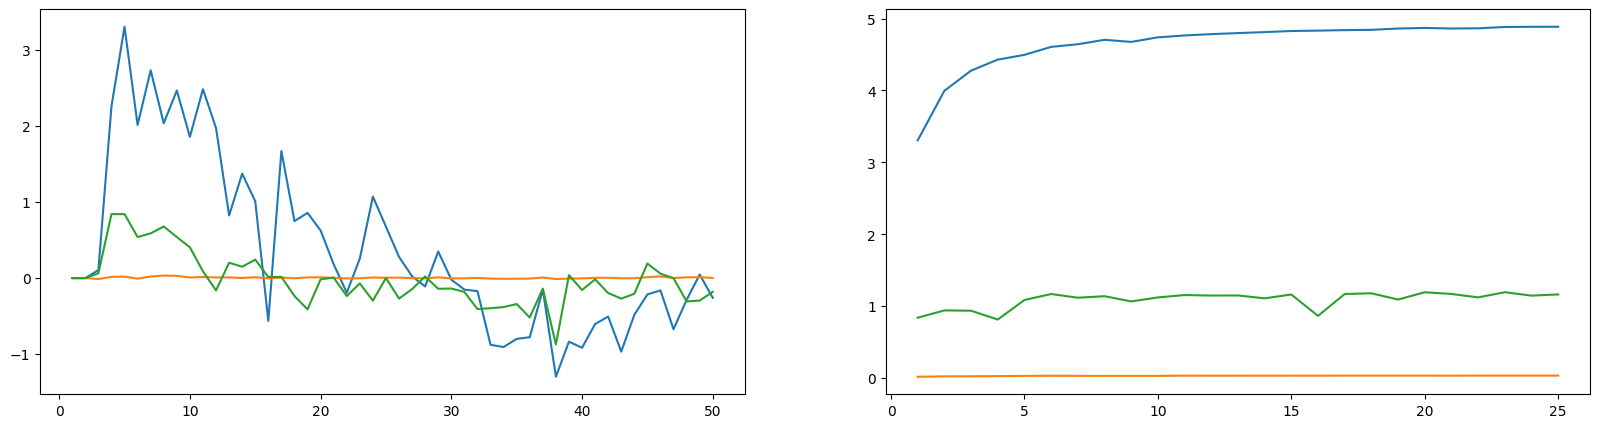

In [12]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
axes[0].plot(range(1,end_k+1),mae_rsis)
axes[0].plot(range(1,end_k+1),wia_rsis)
axes[0].plot(range(1,end_k+1),mape_rsis)
axes[1].plot(range(1,end_eta+1),mae_rsis_eta)
axes[1].plot(range(1,end_eta+1),wia_rsis_eta)
axes[1].plot(range(1,end_eta+1),mape_rsis_eta)

In [31]:
# save result
dic = {"超参数K,eta=1":range(1,end_k+1),"mae":mae_rsis,"wia":wia_rsis,"mape":mape_rsis}
dic2 = {f"超参数eta,k={k_min}":range(1,end_eta+1),"mae":mae_rsis_eta,"wia":wia_rsis_eta,"mape":mape_rsis_eta}
data = pd.DataFrame(dic)
data2 = pd.DataFrame(dic2)
data.to_csv(r"/Users/dyk/Desktop/data/k_fig1-3/D6.csv", index=False)
data2.to_csv(r"/Users/dyk/Desktop/data/eta_fig4-6/D6.csv", index=False)

敏感性分析

In [180]:

end_k = 10
end_eta = 5
dim = 10
n = 200
p = [0.2,0.3,0.5]
repeat = 20
d1 = 5
add_y_noise = True
M_mae = np.zeros((end_k,end_eta))
M_mape = np.zeros((end_k,end_eta))
M_wia = np.zeros((end_k,end_eta))

for k in tqdm(range(1,end_k+1)):
    for eta in range(1,end_eta+1):
        np.random.seed(123)
        mae_list_bf_eta = []
        mae_list_af_eta = []
        wia_list_bf_eta = []
        wia_list_af_eta = []
        mape_list_bf_eta = []
        mape_list_af_eta = []
        for _ in range(repeat):
            w1 = np.random.normal(0,5,(dim,d1))
            w2 = np.random.normal(0,5,(d1,1))
            x,y = generate_dataset(dim,n,w1,w2)
            x = add_noise(x,p)
            if add_y_noise == True:
                y = add_noise(y,p)
            mae_list_bf_eta.append(mae(w1,w2,x,y))
            wia_list_bf_eta.append(wia(f_funcation(x,w1,w2),y))
            mape_list_bf_eta.append(mape(f_funcation(x,w1,w2),y))
            _,_,add_data = interpolation(x,y,k,eta,False)
            y_ture = f_funcation(add_data[:,:-1],w1,w2)
            mae_list_af_eta.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
            wia_list_af_eta.append(wia(y_ture,add_data[:,-1].reshape(-1,1)))
            mape_list_af_eta.append(mape(y_ture,add_data[:,-1].reshape(-1,1)))
        M_mae[k-1,eta-1] = np.mean(mae_list_bf_eta)-np.mean(mae_list_af_eta)
        M_mape[k-1,eta-1] = np.mean(mape_list_bf_eta)-np.mean(mape_list_af_eta)
        M_wia[k-1,eta-1] = np.mean(wia_list_bf_eta)-np.mean(wia_list_af_eta)
        

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:17<00:00, 25.78s/it]


In [8]:
M_mae = pd.read_csv(r"/Users/dyk/Desktop/新论文/data/热力图/mae")
M_mape = pd.read_csv(r"/Users/dyk/Desktop/新论文/data/热力图/mape")
M_wia = pd.read_csv(r"/Users/dyk/Desktop/新论文/data/热力图/wia")

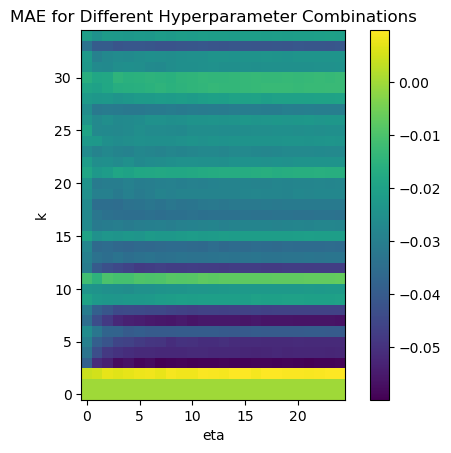

In [13]:
# plt.imshow(M_mae ,origin='lower')
# plt.imshow(M_mape, origin='lower')
plt.imshow(M_wia, origin='lower')
plt.colorbar()
plt.xlabel('eta')
plt.ylabel('k')
plt.title('MAE for Different Hyperparameter Combinations')
plt.show()

#实例数据分析

In [14]:
np.random.seed(12)
n = 500
test_n = 1000
k =15#hyperparameters K
eta = 5#hyperparameters eta
train_data = pd.read_csv(r"/Users/dyk/Desktop/paper/ASIDS/bike-sharing-demand/train.csv")
train_data = train_data.dropna(axis = 0)
# train_data = train_data[(train_data != -200).any(axis=1)]
train_data = train_data.values
print(train_data.shape)
np.random.shuffle(train_data)
x_train = train_data[:n,1:-1]
y_train = train_data[:n,-1]
x_test = train_data[-test_n:,1:-1]
y_test = train_data[-test_n:,-1]
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# min_max_scaler = preprocessing.MinMaxScaler()
# x_train = min_max_scaler.fit_transform(x_train)
# y_train = min_max_scaler.fit_transform(y_train.reshape(-1,1))+0.1
# x_test = min_max_scaler.fit_transform(x_test)
# y_test = min_max_scaler.fit_transform(y_test.reshape(-1,1))+0.1

_,_,data = interpolation(x_train,y_train,k,eta,False)
x_train_RSIS = data[:,:-1]
y_train_RSIS = data[:,-1].reshape(-1,1)
print(f"sample size:{x_train.shape[0]}\nafter RSIS:{x_train_RSIS.shape[0]}")

(10886, 12)
sample size:500
after RSIS:2999


In [15]:
#knn
from sklearn import neighbors
min_value = 100*100
min_mape = 100*100
for k in range(1,50,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train,y_train)
    y_pred = modelKNN.predict(x_test)
    m = mean_absolute_error(y_pred,y_test)
    if  m <= min_value:
        min_value = m
        c = k
    ma = mape(y_test.reshape(-1),y_pred)
    if ma <= min_mape:
        min_mape = ma

   
print(f"before RSIS , k:,{c},  MAE:{min_value}, mape:{min_mape}")
min_value = 100*100
min_mape = 100*100
for k in range(1,120,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train_RSIS,y_train_RSIS)
    y_pred = modelKNN.predict(x_test)
    m = mean_absolute_error(y_pred,y_test)
    if  m <= min_value:
        min_value = m
        c = k
    ma = mape(y_test.reshape(-1),y_pred)
    if ma <= min_mape:
        min_mape = ma

print(f"after RSIS , k:,{c},  MAE:{min_value}, mape:{min_mape}")

before RSIS , k:,6,  MAE:6.19232630321287, mape:0.15729060426315816
after RSIS , k:,6,  MAE:4.192904638313031, mape:0.14633344980846014


In [16]:
#MLP
# np.random.seed(123)
from sklearn.neural_network import MLPRegressor
model =MLPRegressor()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
mse1 = mean_absolute_error(y_pred,y_test)

print(f"mape:{mape(y_test.reshape(-1),y_pred)},{r2_score(y_test.reshape(-1),y_pred)}")
model =MLPRegressor()
model.fit(x_train_RSIS,y_train_RSIS)
y_pred = model.predict(x_test)
mes2 = mean_absolute_error(y_pred,y_test)
print("before RSIS MAE:%f\nafter RSIS MAE:%f"%(mse1,mes2))

print(f"mape:{mape(y_test.reshape(-1),y_pred)},{r2_score(y_test.reshape(-1),y_pred)}")

mape:0.03590846275726256,0.9999721802840157
before RSIS MAE:0.721586
after RSIS MAE:0.336198
mape:0.01443197058052495,0.9999927219503395


In [805]:
from sklearn.svm import SVR

model1 = SVR(kernel="rbf")
model1.fit(x_train,y_train)
y_pred=model1.predict(x_test)
mse1 = mean_absolute_error(y_test,y_pred)
print(f"mape:{mape(y_test.reshape(-1),y_pred)}")
model1 = SVR(kernel="rbf")
model1.fit(x_train_RSIS,y_train_RSIS)
y_pred=model1.predict(x_test)
mse2 = mean_absolute_error(y_test,y_pred)
print("原数据集MAS:%f\n处理后数据集MAE:%f"%(mse1,mse2))
print(f"mape:{mape(y_test.reshape(-1),y_pred)}")

mape:0.13571071046634686
原数据集MAS:0.076196
处理后数据集MAE:0.077769
mape:0.14141773936358173


In [857]:
#GBDT
from sklearn.ensemble import GradientBoostingRegressor
for i in range(10,201,20):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train,y_train)
    y_pred = model2.predict(x_test)
    print("before RSIS, loss:%f , n_estimators:%d,mape:%f"%(mean_absolute_error(y_test,y_pred),i,mape(y_test.reshape(-1),y_pred)))
    # print(f"mape:{}")
for i in range(10,201,10):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train_RSIS,y_train_RSIS)
    y_pred = model2.predict(x_test)
    print("after RSIS, loss:%f , n_estimators:%d , mape%f"%(mean_absolute_error(y_test,y_pred),i,mape(y_test.reshape(-1),y_pred)))

before RSIS, loss:55.837635 , n_estimators:10,mape:3.563718
before RSIS, loss:10.720322 , n_estimators:30,mape:0.614648
before RSIS, loss:5.371216 , n_estimators:50,mape:0.203697
before RSIS, loss:4.591849 , n_estimators:70,mape:0.101915
before RSIS, loss:4.359750 , n_estimators:90,mape:0.067329
before RSIS, loss:4.140206 , n_estimators:110,mape:0.051886
before RSIS, loss:3.971636 , n_estimators:130,mape:0.044472
before RSIS, loss:3.830977 , n_estimators:150,mape:0.041545
before RSIS, loss:3.701792 , n_estimators:170,mape:0.036411
before RSIS, loss:3.556845 , n_estimators:190,mape:0.034449
after RSIS, loss:83.303358 , n_estimators:10 , mape6.790708
after RSIS, loss:33.926519 , n_estimators:20 , mape2.937174
after RSIS, loss:15.757101 , n_estimators:30 , mape1.308165
after RSIS, loss:9.103926 , n_estimators:40 , mape0.695780
after RSIS, loss:6.502016 , n_estimators:50 , mape0.422820
after RSIS, loss:5.323743 , n_estimators:60 , mape0.293981
after RSIS, loss:4.618826 , n_estimators:70 , 

In [667]:
#RF
from sklearn.ensemble import RandomForestRegressor
for i in range(20,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train,y_train)
    y_pred = regressor.predict(x_test)
    print("before RSIS, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))
for i in range(20,201,20):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train_RSIS, y_train_RSIS)
    y_pred = regressor.predict(x_test)
    print("after RSIS, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))

before RSIS, loss:0.061535 , n_estimators:20
before RSIS, loss:0.062747 , n_estimators:40
before RSIS, loss:0.062312 , n_estimators:60
before RSIS, loss:0.060882 , n_estimators:80
before RSIS, loss:0.061578 , n_estimators:100
before RSIS, loss:0.061296 , n_estimators:120
before RSIS, loss:0.060943 , n_estimators:140
before RSIS, loss:0.060729 , n_estimators:160
before RSIS, loss:0.060468 , n_estimators:180
before RSIS, loss:0.060814 , n_estimators:200
after RSIS, loss:0.069807 , n_estimators:20
after RSIS, loss:0.076523 , n_estimators:40
after RSIS, loss:0.074725 , n_estimators:60
after RSIS, loss:0.075585 , n_estimators:80
after RSIS, loss:0.074847 , n_estimators:100
after RSIS, loss:0.074546 , n_estimators:120
after RSIS, loss:0.073328 , n_estimators:140
after RSIS, loss:0.073426 , n_estimators:160
after RSIS, loss:0.073561 , n_estimators:180
after RSIS, loss:0.073894 , n_estimators:200


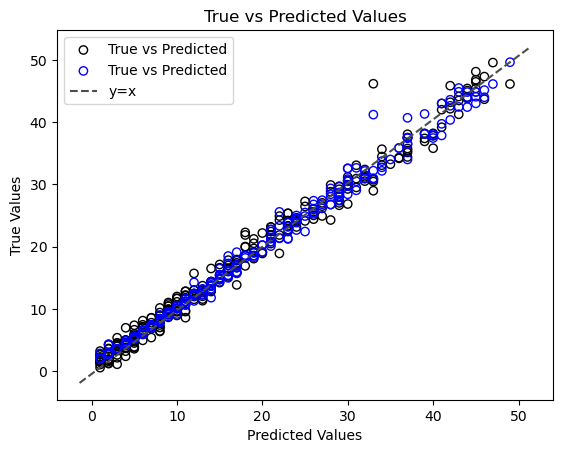

In [867]:
import matplotlib.pyplot as plt
import numpy as np

model2 = GradientBoostingRegressor(n_estimators=110)
model2.fit(x_train,y_train)
y_pred = model2.predict(x_test)
# 假设有一些真实值和预测值
true_values = y_test[np.where(y_test<=50)]
nums = (y_pred[np.where(y_test<=50)]).shape
predicted_values = y_pred[np.where(y_test<=50)]

# 创建图形和轴
fig, ax = plt.subplots()

# 绘制散点图：真实值 vs 预测值
ax.scatter(true_values, predicted_values, edgecolors='k', facecolors='none', label='True vs Predicted')


model2 = GradientBoostingRegressor(n_estimators=200)
model2.fit(x_train_RSIS,y_train_RSIS)
y_pred = model2.predict(x_test)
predicted_values1 = y_pred[np.where(y_test<=50)]


ax.scatter(true_values, predicted_values1,  facecolors='none', label='True vs Predicted', color='blue',)
# 绘制 y=x 线
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3", label='y=x')

# 设置标签和标题
ax.set_xlabel('Predicted Values')
ax.set_ylabel('True Values')
ax.set_title('True vs Predicted Values')

# 显示图例
ax.legend()

# 显示图形
plt.show()
dic = {"真实y":true_values,"优化前y_hat":predicted_values,"优化后y_hat":predicted_values1}

data = pd.DataFrame(dic)

data.to_csv(r"/Users/dyk/Desktop/prediction/RF.csv", index=False)

复杂函数下进一步分析

In [54]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def f_funcation(x,w1,w2):
    x = x@w1
    for i in range(x.shape[1]):
        if i % 3 == 0:
            x[:, i] = sigmoid(x[:, i])
        elif i % 5 == 1:
            x[:, i] = tanh(x[:, i])
        else:
            x[:, i] = x[:, i]

    
    return x@w2

def generate_dataset(d,n,w1,w2):
    x = np.random.normal(0,10,(n,d))
    # x = t.rvs(10, size=(n,d))
    y = f_funcation(x,w1,w2)
    y = y.reshape(-1,1)
    data = np.hstack((x,y))
    np.random.shuffle(data)
    return data[:,:-1],data[:,-1].reshape(-1,1)

def mae(w1,w2,x,y):
    erro = y-f_funcation(x,w1,w2)
    return np.sum(np.abs(erro))/x.shape[0]

dim = 10
n = 200
p = [0.2,0.3,0.5]
eta = 1
repeat = 1
d1 = 5
end_k = 61
end_eta = 15
eta_walk = 0.5
arfa_end = 100
add_y_noise = True

bf_rsis = []
af_rsis = []
for k in tqdm(range(1,end_k)):
    mae_list_bf_rsis = []
    mae_list_af_rsis = []
    np.random.seed(123)
    for i in range(repeat):
        w1 = np.random.normal(0,5,(dim,d1))
        w2 = np.random.normal(0,5,(d1,1))
        x,y = generate_dataset(dim,n,w1,w2)
        x = add_noise(x,p)
        if add_y_noise == True:
            y = add_noise(y,p)
        mae_list_bf_rsis.append(mae(w1,w2,x,y))
        _,_,add_data = interpolation(x,y,k,eta,False)
        mae_list_af_rsis.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
    
    bf_rsis.append(np.mean(mae_list_bf_rsis))
    af_rsis.append(np.mean(mae_list_af_rsis))

# 使用enumerate获取值和索引，然后根据值排序
sorted_indices = list_sort(af_rsis)


dif_k_eta = np.zeros((len(sorted_indices),int(end_eta/eta_walk)-1))
row = 0

for k in tqdm(sorted_indices):
    eta = 1
    line = 0
    while eta <= end_eta:
    # for eta in range(1,end_eta):
        np.random.seed(123)
        eta_af_rsis1 = []
        for i in range(repeat):
            w1 = np.random.normal(0,5,(dim,d1))
            w2 = np.random.normal(0,5,(d1,1))
            x,y = generate_dataset(dim,n,w1,w2)
            x = add_noise(x,p)
            if add_y_noise == True:
                y = add_noise(y,p)
            _,_,add_data = interpolation(x,y,k+1,eta,False)
            eta_af_rsis1.append(mae(w1,w2,add_data[:,:-1],add_data[:,-1].reshape(-1,1)))
        
        
        eta += 0.5
        dif_k_eta[row,line] = np.mean(eta_af_rsis1)
        line += 1
    row += 1


np.random.seed(123)
walk = 0.5
eta_arfa = np.zeros((4,np.int(arfa_end/walk)+1))
k = sorted_indices[0]+1
w1 = np.random.normal(0,5,(dim,d1))
w2 = np.random.normal(0,5,(d1,1))
x,y = generate_dataset(dim,n,w1,w2)
x = add_noise(x,p)
if add_y_noise == True:
    y = add_noise(y,p)

row = 0
for eta in tqdm([1,0.5,5]):
    np.random.seed(123)
    line = 0
    arfa = 0
    _,_,add_data = interpolation(x,y,k,eta,False)
    while arfa <= arfa_end:
        erro = np.abs(add_data[:,-1].reshape(-1,1)-f_funcation(add_data[:,:-1],w1,w2))
        eta_arfa[row,line] = np.sum(erro[:,0] > arfa)/add_data.shape[0]
        if eta == 1:
            erro = np.abs(y.reshape(-1,1)-f_funcation(x,w1,w2))
            eta_arfa[-1,line] = np.sum(erro[:,0] > arfa)/x.shape[0]
        arfa += walk
        line += 1
    row += 1


100%|██████████| 3/3 [00:00<00:00,  4.26it/s]
